## Setup & Imports

In [38]:
import numpy as np
import random 

from tqdm import tqdm
import glob

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [39]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights
from torchvision import models

In [40]:
from torchvision.models.segmentation.fcn import _fcn_resnet
from torchgeo.models import resnet, resnet50

from torchgeo.datasets import LoveDA

### GPU

In [41]:
!nvidia-smi

Sat Feb 11 19:22:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:16:00.0 Off |                    0 |
| N/A   45C    P0    55W / 300W |  32438MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## UNet Model

In [42]:
# double convolutional layer which is executed in every step of the u-net 
# conv layer takes as input number of input channels -> in_channels and outputs vice versa
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    # forward pass in the conv layer 
    def forward(self, x):
        return self.conv(x)

# design complete u-net shape 
# model takes as default 3 input channels and 6 output channels
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=6, features=[64, 128, 256, 512],  # features -> num of input nodes at every stage in the model 
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):  # reverse the features i.o. to move upwards in the model 
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        # lowest stage in u-net 
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # final conv layer: takes in 64 channels and outputs 1 channel by default 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    # forward pass of the u-net model between stages 
    def forward(self, x):
        skip_connections = []  # red arrows in the model representation 

        for down in self.downs:
            x = down(x)  # one DoubleConv run-through 
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

## Data Import and Preprocessing

In [43]:
path='/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/LoveDA'

In [44]:
love_train = LoveDA(
    root=path, 
    split='train', 
    scene=['urban', 'rural'], 
    transforms=None, 
    download=True, 
    checksum=False)

love_val = LoveDA(
    root=path, 
    split='val', 
    scene=['urban', 'rural'], 
    transforms=None, 
    download=True, 
    checksum=False)

print(f"""
      Train data: {len(love_train)}
      Validation data: {len(love_val)}
      """)

train
Files already downloaded and verified
val
Files already downloaded and verified

      Train data: 2522
      Validation data: 1669
      


In [45]:
rand_idx = random.randint(0, len(love_train))

img = love_train[rand_idx]['image'].to(torch.uint8)
mask = love_train[rand_idx]['mask']

#### Labels:

- unknown - 0
- background – 1
- building – 2
- road – 3
- water – 4
- barren – 5
- forest – 6
- agriculture – 7

In [46]:
RGB_classes = [
       (0, 0, 0),
       (255, 255, 225),
       (255,  0, 255),
       (255, 0, 0),
       (0,  0,  255), 
       (128, 128, 128),
       (0, 130, 0),
       (255, 200, 0)]

idx2rgb = {key: value for key, value in enumerate(RGB_classes)}

In [47]:
# Create the RGB tensor
rgb_tensor = torch.zeros((img.shape), dtype=torch.uint8)
for index in idx2rgb:
    for channel, color in enumerate(idx2rgb[index]):
        rgb_tensor[channel][mask == index] = color

In [48]:
transform = torchvision.transforms.ToPILImage()

image = transform(img).convert('RGB')
mask_img = transform(rgb_tensor)

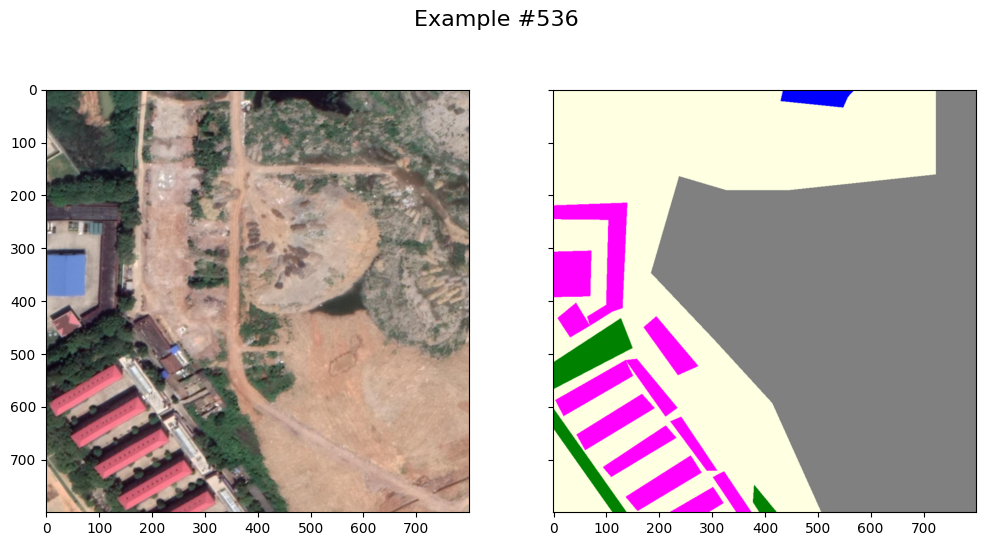

In [49]:
SIZE = 800

im1 = image.resize((SIZE, SIZE))
im2 = mask_img.resize((SIZE, SIZE))

f, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)

f.suptitle(f"Example #{rand_idx}", fontsize=16)
plt.show()

## Utilitiy Functions

### Transformers

In [50]:
def build_transforms(image_size): 

    train_transform = A.Compose([
    A.Resize(
        height=image_size, 
        width=image_size),
    A.Flip(p=0.5),
    A.ToGray(p=0.25),
    A.ColorJitter(p=0.25),
    A.Normalize(
        mean=(0.485, 0.456, 0.406), 
        std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ],)
        
    val_transform = A.Compose([
        A.Resize(
            height=image_size, 
            width=image_size),
        A.Normalize(
            mean=(0.485, 0.456, 0.406), 
            std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ],)

    return train_transform, val_transform

In [51]:
def apply_train_transforms(sample):
  
    # transform function expects numpy array of the form (W, H, C)
    image = np.array(sample['image'].permute(1, 2, 0))
    mask = np.array(sample['mask'])

    augmented = train_transform(image=image, mask=mask)
    image = augmented['image']
    mask = augmented['mask']

    return {'image': image, 'mask': mask}


def apply_val_transforms(sample):
  
    # transform function expects numpy array of the form (W, H, C)
    image = np.array(sample['image'].permute(1, 2, 0))
    mask = np.array(sample['mask'])

    augmented = val_transform(image=image, mask=mask)
    image = augmented['image']
    mask = augmented['mask']

    return {'image': image, 'mask': mask}

### Data Loader

In [52]:
def get_loaders(
    batch_size,
    num_workers = 2,
    pin_memory = True,
):

    train_data = LoveDA(
        root=path, 
        split='train', 
        scene=['urban', 'rural'], 
        transforms=apply_train_transforms, 
        download=False, 
        checksum=False,)

    train_loader = DataLoader(
            love_train,
            batch_size = batch_size,
            num_workers = num_workers,
            pin_memory = pin_memory,)

    val_data = LoveDA(
        root=path, 
        split='val', 
        scene=['urban', 'rural'], 
        transforms=apply_val_transforms, 
        download=False, 
        checksum=False,)

    val_loader = DataLoader(
            val_data,
            batch_size = batch_size,
            num_workers = num_workers,
            pin_memory = pin_memory,)
  
    return train_loader, val_loader

### Evaluation

In [53]:
def check_accuracy(loader, model, pretrained=False, device="cuda"):
  
  num_correct = 0
  num_pixels = 0

  model.eval()
  with torch.no_grad():
      for batch in loader:
          x = batch['image'].to(device)
          y = batch['mask']
          
          # compute probabilities
          if pretrained:
            probs = torch.nn.Softmax(model(x)['out'])
          else:
            probs = torch.nn.Softmax(model(x))
          
          # get predictions by choosing highest probability 
          preds = torch.argmax(probs.dim, axis=1).cpu()
          num_correct += (preds == y).sum().item()
          num_pixels += torch.numel(preds)

  print(
      f"Got {num_correct}/{num_pixels} pixels correct with acc {num_correct/num_pixels*100:.2f}"
  )

### Save & Load Model

In [54]:
def save_checkpoint(state, filename="love_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

## Training

In [55]:
# Specify number of classes for segmentation task
OUTPUT_CHANNELS = 8

In [56]:
# Specify model
MODEL = models.segmentation.deeplabv3_resnet101(weights='DEFAULT')

# Freeze all layers but classification layer
for param in MODEL.parameters():
  param.requires_grad = False

MODEL.classifier = DeepLabHead(2048, OUTPUT_CHANNELS)
MODEL.aux_classifier = None

### Hyperparameter

In [57]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
NUM_EPOCHS = 2

IMAGE_SIZE = 800  # 1024 originally

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
PIN_MEMORY = True

LOAD_MODEL = False
PRETRAINED = True
GEO_PRETRAINED = False
FREEZE = True # if True -> only train last layer

### Train Function

In [58]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    
  model.train()
  loop = tqdm(loader, desc="Training")

  for batch_idx, batch in enumerate(loop):
    
    data = batch['image'].type(torch.float).to(device=DEVICE)
    targets = batch['mask'].type(torch.LongTensor).to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      if PRETRAINED or GEO_PRETRAINED:
        predictions = model(data)['out']
      else:
        predictions = model(data)

      loss = loss_fn(predictions, targets)

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())

### Train Loop

In [59]:
def main():

    train_transform, val_transform = build_transforms(
        image_size=IMAGE_SIZE)

    train_loader, val_loader = get_loaders(
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,)
  
    # Load pre-trained DeepLapV3 ResNet101
    if PRETRAINED:
        MODEL = models.segmentation.deeplabv3_resnet101(
            weights=DeepLabV3_ResNet101_Weights.DEFAULT)
        MODEL.classifier = DeepLabHead(2048, OUTPUT_CHANNELS)
        MODEL.aux_classifier = None

    elif GEO_PRETRAINED:
        weights_backbone = resnet.ResNet50_Weights.SENTINEL2_RGB_SECO
        backbone = resnet50(weights=weights_backbone)
        MODEL = _fcn_resnet(backbone, OUTPUT_CHANNELS, aux=False)

    # Load UNet-Model
    else: 
        MODEL = UNET(in_channels=3, out_channels=OUTPUT_CHANNELS)

    # Train only classifier (last layer)
    if PRETRAINED or GEO_PRETRAINED:
        if FREEZE:
            for name, param in MODEL.named_parameters():
                if "classifier" not in name:
                    param.requires_grad = False

    MODEL = MODEL.to(device=DEVICE)

    # Class weights for multi-class classification
    # unknown, background, building, road, water, barren, forest, agriculture
    weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
    class_weights = torch.FloatTensor(weights).cuda()

    CRITERION = nn.CrossEntropyLoss(weight = class_weights).to(device=DEVICE)
    OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), MODEL)

    SCALER = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        print(f"Start epoch: {epoch+1}")
        #print(f"Learning Rate: {SCHEDULER.get_last_lr()[0]}")
        
        # Train model
        train_fn(train_loader, MODEL, OPTIMIZER, CRITERION, SCALER)
        
        # save model
        checkpoint = {
            "state_dict": MODEL.state_dict(),
            "optimizer": OPTIMIZER.state_dict(),
        }
        save_checkpoint(checkpoint)
        
        # check accuracy
        pre = PRETRAINED or GEO_PRETRAINED
        check_accuracy(val_loader, MODEL, pretrained=pre, device=DEVICE)
        
        print(f"End epoch: {epoch+1} \n")

### Run Train Loop

In [60]:
# Train DeepLab3 ResNet101
print(f"Cuda available: {torch.cuda.is_available()}")

Cuda available: True


### Predictions

In [61]:
if PRETRAINED:
  trained_model = models.segmentation.deeplabv3_resnet101()

# More than last classifier layer

  trained_model.classifier = DeepLabHead(2048, OUTPUT_CHANNELS)
  trained_model.aux_classifier = None
  trained_model = trained_model.to(device='cuda')

  load_checkpoint(torch.load("love_checkpoint.pth.tar"), trained_model)
  
else: 
  trained_model = UNET(in_channels=3, out_channels=4).to(device='cuda')
  load_checkpoint(torch.load("my_checkpoint.pth.tar"), trained_model)

=> Loading checkpoint


In [62]:
def predictions(image, model, device):
    
    img = image.unsqueeze(0).type(torch.float).to(device=DEVICE)
    
    model.eval()
    with torch.no_grad():
        
        predictions = model(img)['out']
        pred_labels = torch.argmax(predictions, axis=1).cpu().squeeze(0)
        
        # Create the RGB tensor
        rgb_tensor = torch.zeros((1024, 1024, 3), dtype=torch.uint8)
        for index in idx2rgb:
            rgb_tensor[pred_labels == index] = torch.tensor(idx2rgb[index], dtype=torch.uint8)
            
        rgb_tensor = rgb_tensor.permute(2, 0, 1)
        
        return rgb_tensor

In [72]:
set_idx = 400
img = love_train[set_idx]['image'].to(torch.uint8)
image = transform(img)

pred_mask = transform(
    predictions(
        img, 
        trained_model, 
        DEVICE))

In [73]:
# Create the RGB tensor
rgb_tensor = torch.zeros((1024, 1024, 3), dtype=torch.uint8)
for index in idx2rgb:
    rgb_tensor[mask == index] = torch.tensor(idx2rgb[index], dtype=torch.uint8)
    
rgb_tensor = rgb_tensor.permute(2, 0, 1)

mask = transform(rgb_tensor)

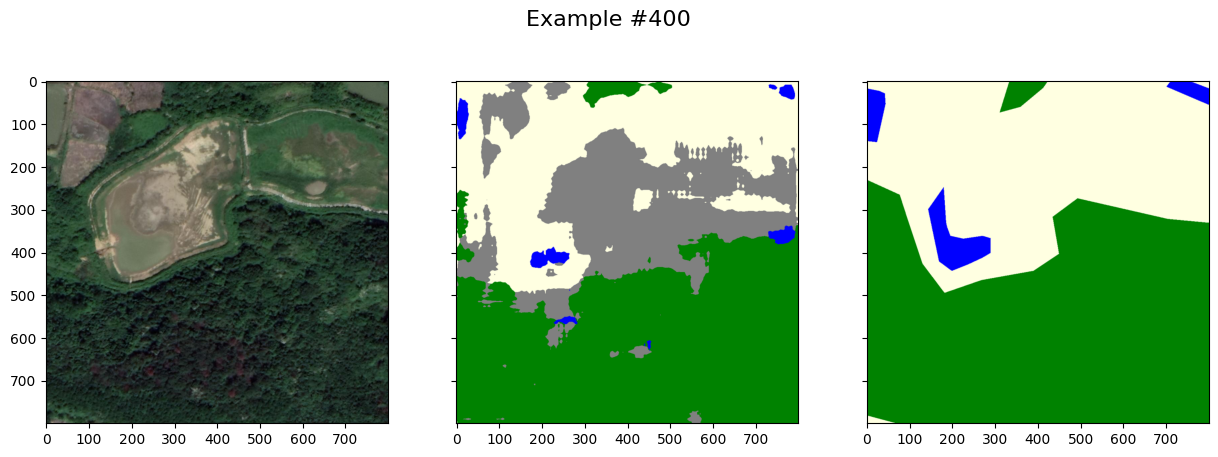

In [74]:
SIZE = 800

im1 = image.resize((SIZE, SIZE))
im2 = pred_mask.resize((SIZE, SIZE))
im3 = mask.resize((SIZE, SIZE))

f, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)
ax[2].imshow(im3)

f.suptitle(f"Example #{set_idx}", fontsize=16)
plt.show()

## Test Accuracy Function

In [24]:
MODEL = models.segmentation.deeplabv3_resnet101(
        weights=DeepLabV3_ResNet101_Weights.DEFAULT)
MODEL.classifier = DeepLabHead(2048, OUTPUT_CHANNELS)
MODEL.aux_classifier = None

MODEL = MODEL.to(device=DEVICE)

In [26]:
train_transform, val_transform = build_transforms(
    image_size=IMAGE_SIZE)

train_loader, val_loader = get_loaders(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,)

train
val


In [27]:
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

In [28]:
x_train = train_batch['image'].type(torch.float).to(device=DEVICE)
x_val = val_batch['image'].type(torch.float).to(device=DEVICE)

In [128]:
x_train.shape

torch.Size([8, 3, 1024, 1024])

In [30]:
predictions = MODEL(x_train)

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 31.74 GiB total capacity; 30.50 GiB already allocated; 62.25 MiB free; 30.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF